<a href="https://colab.research.google.com/github/hoihui/pkgs/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

# Transfer learning for cats/dogs

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%207%20-%20Loading%20Image%20Data%20(Solution).ipynb

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%208%20-%20Transfer%20Learning%20(Solution).ipynb

## prepare data

In [ ]:
import urllib.request,zipfile
import os,tempfile
os.chdir(tempfile.gettempdir())
urllib.request.urlretrieve('https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip','Cat_Dog_data.zip')
zipfile.ZipFile('Cat_Dog_data.zip').extractall()

Dataloader:

In [23]:
import torch
from torchvision import datasets, transforms
train_transforms = transforms.Compose([transforms.RandomRotation(30),     # add randomization for robustness
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder('Cat_Dog_data/train', transform=train_transforms)
test_data = datasets.ImageFolder('Cat_Dog_data/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

Example image/label:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


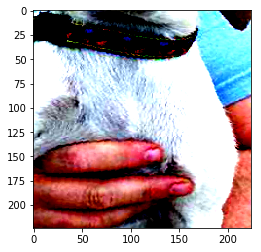

In [37]:
import matplotlib.pyplot as plt
images, labels = next(iter(trainloader))
image, label = images[0], labels[0]
image = image.numpy().transpose((1, 2, 0))
plt.imshow(image)
print(label)

## Load Densenet

In [30]:
from torch import nn
from torchvision import models

In [48]:
model = models.densenet121(pretrained=True)

for param in model.parameters():      # Freeze parameters of the feature detector
    param.requires_grad = False
    
print(f"old: {model.classifier}")     # seeing the input is 1024, we need to match it in our own classifier
from collections import OrderedDict   # create our own (binary) classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 256)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(256, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))    
model.classifier = classifier
print(f"new: {model.classifier}")

old: Linear(in_features=1024, out_features=1000, bias=True)
new: Sequential(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (output): LogSoftmax()
)


## Train

In [43]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # only classifier's parameters

estimate time on cpu/gpu:

In [47]:
import time
for device in ['cpu', 'cuda'][:torch.cuda.is_available()+1]:
    model.to(device)
    
    (inputs, labels) = next(iter(trainloader))
    inputs, labels = inputs.to(device), labels.to(device)

    start = time.time()
    loss = criterion( model(inputs) , labels)
    loss.backward()
    optimizer.step()
        
    print(f"Device = {device}; First batch: {(time.time() - start):.3f} seconds")

Device = cpu; First batch: 3.553 seconds


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if it's available
model.to(device)

epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()